# 데이터
- 삼성전자 과거의 일자별 시세
- 데이터 기간 : 2020-05-18 ~ 2021-05-18
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 종가(Close)만 사용

# STEP 1 : 시계열 데이터 준비

In [1]:
# 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']    # 종가만 가져옴

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.0,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.0,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.0,16450920
2021-05-17,80800.0,80900.0,79200.0,79600.0,79600.0,17740855
2021-05-18,79600.0,80000.0,79100.0,79600.0,79600.0,17265868


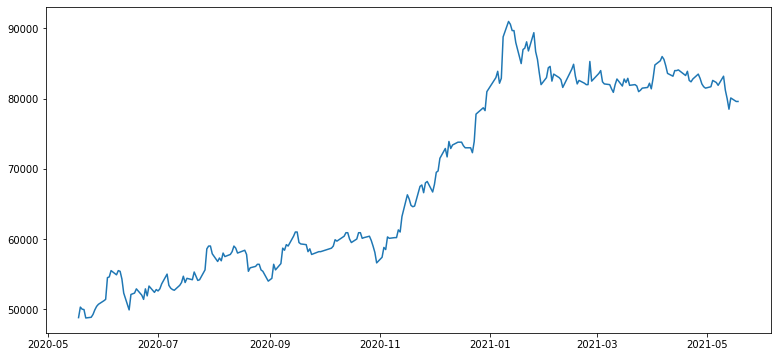

In [4]:
# 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

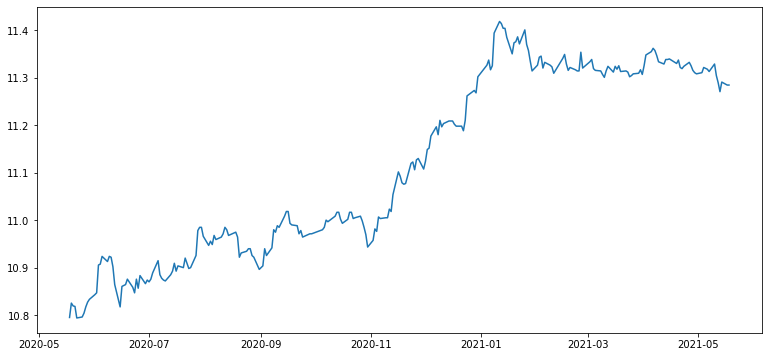

In [7]:
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [8]:
# 일정 시간 내 구간 통계치를 시각화해보기

def plot_rolling_statistics(timeseries, window=12):
    
    # 현재 타임스텝 ~ window에 주어진 타임스텝 이전 사이 구간의 평균, 표준편차
    rolmean = timeseries.rolling(window=window).mean()       # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std()         # 이동 표준편차 시계열
    
    # 원본 시계열, 이동 평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

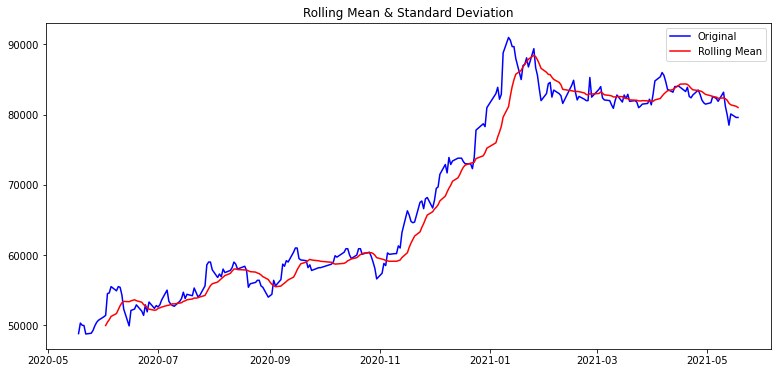

In [9]:
plot_rolling_statistics(ts, window=12)

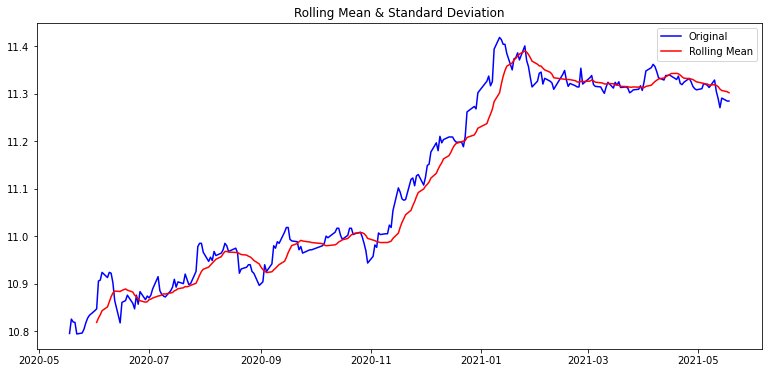

In [10]:
plot_rolling_statistics(ts_log, window=12)

# Stationary 여부 체크하기

# Augmented Dickey-Fuller Test

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(ts) 

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- 시계열이 안정적이지 않다는 귀무가설의 p value가 1에 가깝다.    
  -> 기각 불가          
  -> 시계열이 안정적이지 않다

In [13]:
augmented_dickey_fuller_test(ts_log)   

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- p value 값 약 0.1 감소

# Moving average 제거
- 추세 상쇄하기 : Moving Average(rolling mean)을 구해서 ts_log에서 빼기

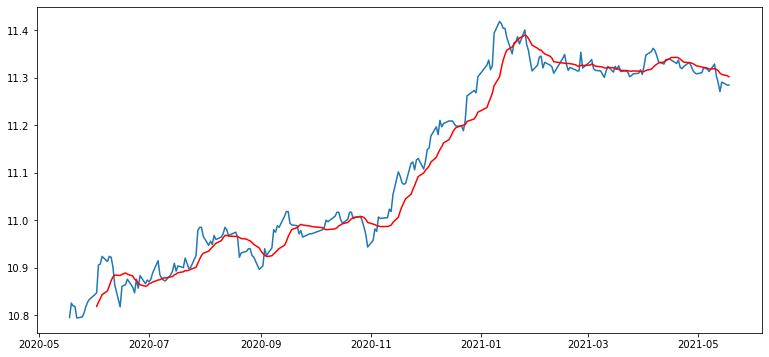

In [14]:
moving_avg = ts_log.rolling(window=12).mean()      
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [15]:
ts_log_moving_avg = ts_log - moving_avg  # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [16]:
# window size가 12이면 앞의 11개 데이터는 계산되지 않기 때문에 그로 인해 생기는 결측치를 제거

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(10)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
Name: Close, dtype: float64

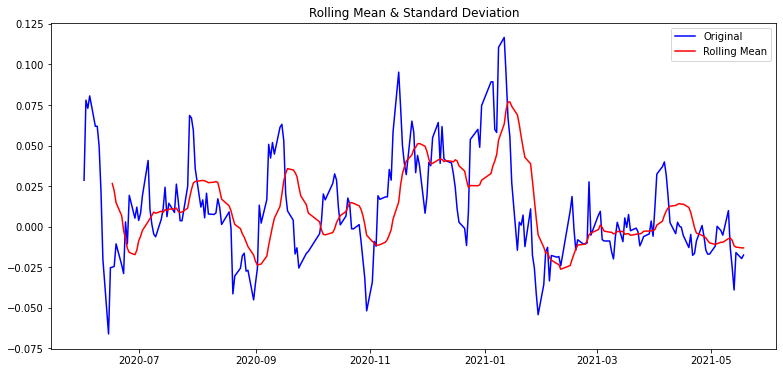

In [17]:
# 정성, 정량적 분석하기

plot_rolling_statistics(ts_log_moving_avg)

In [18]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


- pvalue가 많이 줄어듬

In [19]:
# window = 6
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

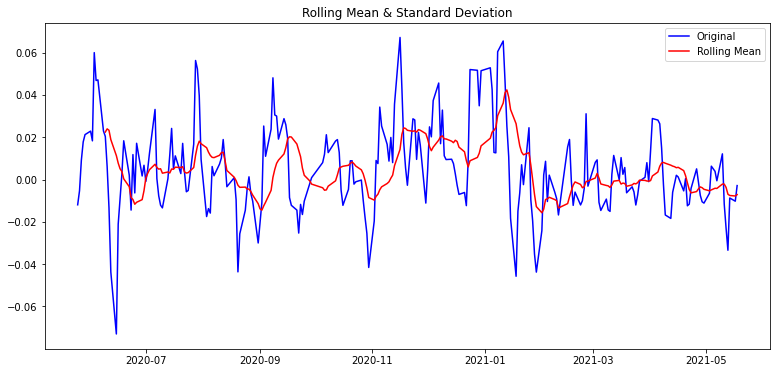

In [20]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [21]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)   

Results of Dickey-Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


- window=12 보다 안정적으로 나옴

# 차분(Differencing) - 계절성(Seasonality) 상쇄하기

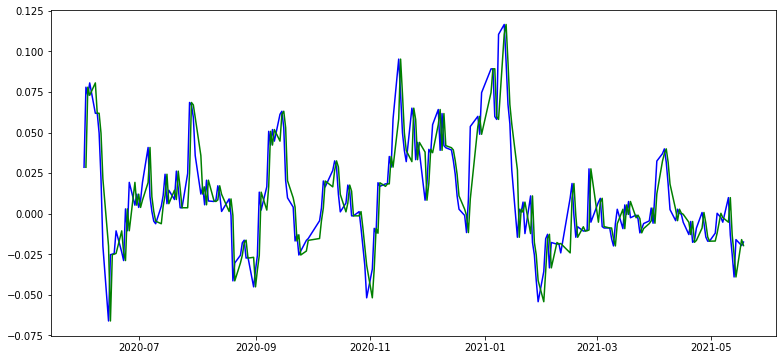

In [22]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

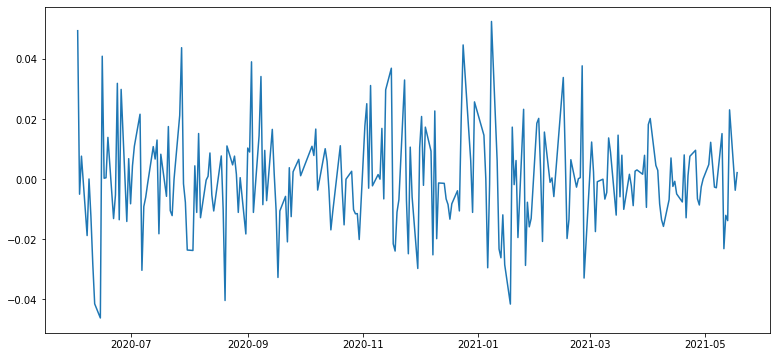

In [23]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

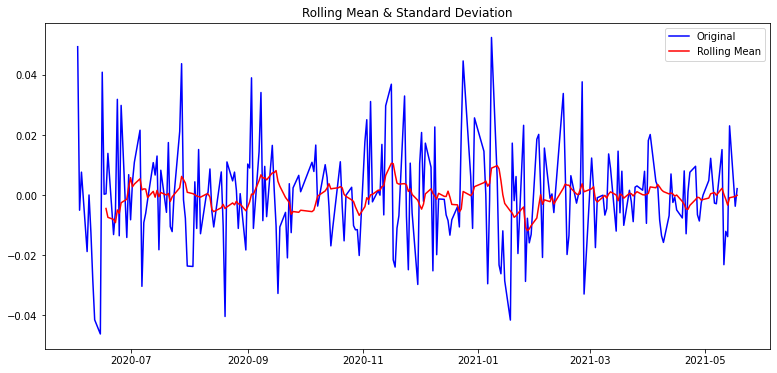

In [24]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [25]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


- pvalue가 2.711476e-28까지 줄어듬 

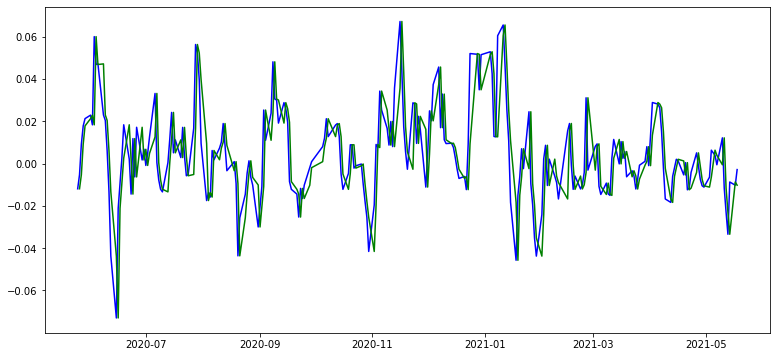

In [26]:
# 6개월 주기
ts_log_moving_avg_shift_6 = ts_log_moving_avg_6.shift()

plt.plot(ts_log_moving_avg_6, color='blue')
plt.plot(ts_log_moving_avg_shift_6, color='green')

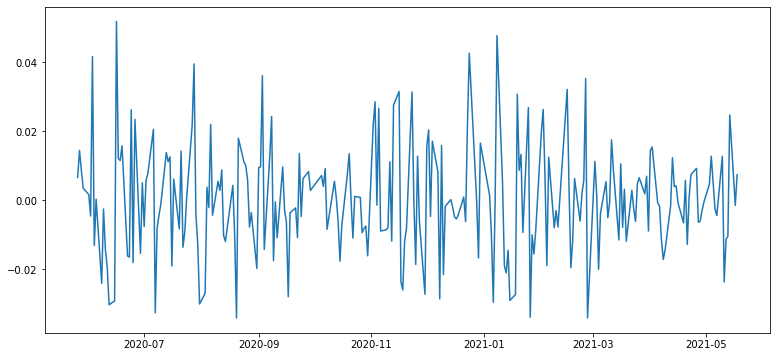

In [27]:
ts_log_moving_avg_diff_6 = ts_log_moving_avg_6 - ts_log_moving_avg_shift_6
ts_log_moving_avg_diff_6.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff_6)

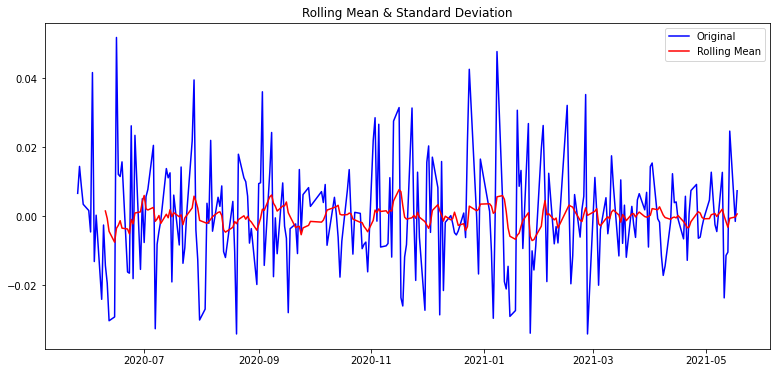

In [28]:
plot_rolling_statistics(ts_log_moving_avg_diff_6)

In [29]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff_6)

Results of Dickey-Fuller Test:
Test Statistic                -1.074520e+01
p-value                        2.753116e-19
#Lags Used                     4.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


# 시계열 분해

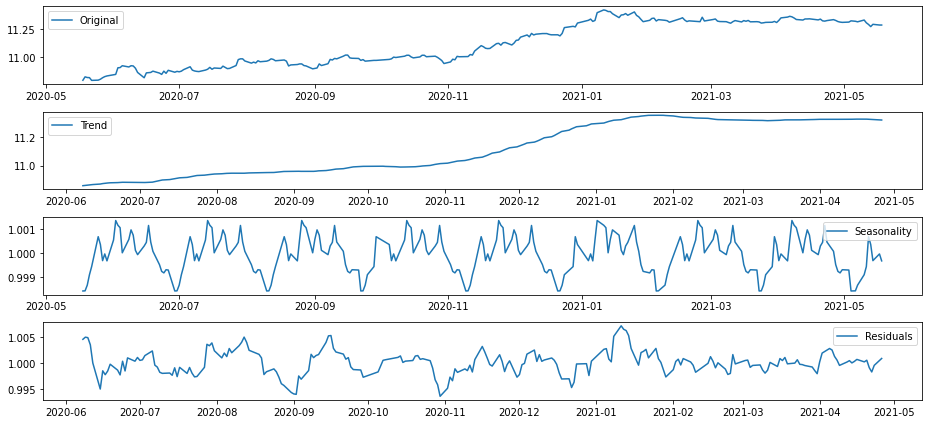

In [30]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')        # Residual = trend와 Seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

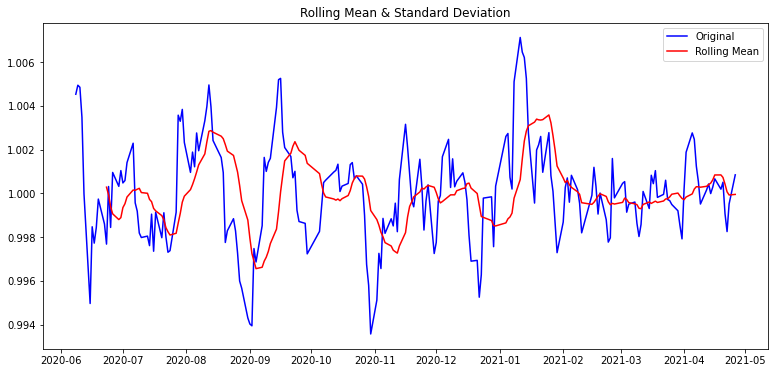

In [31]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

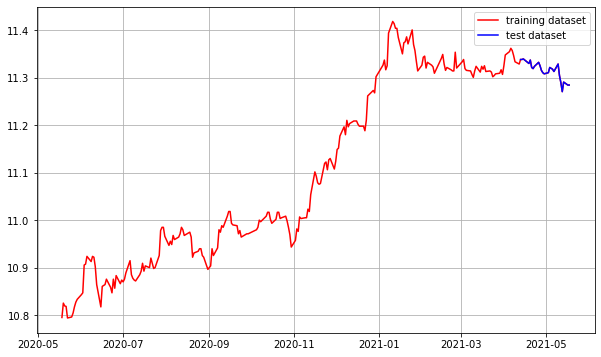

In [33]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [34]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


# STEP 5 : 적정 ARIMA 모수 찾기

## ACF, PACF 그려보기 -> p,q 구하기

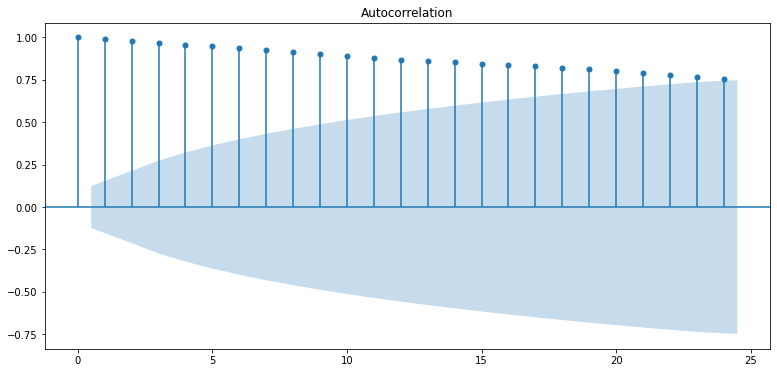

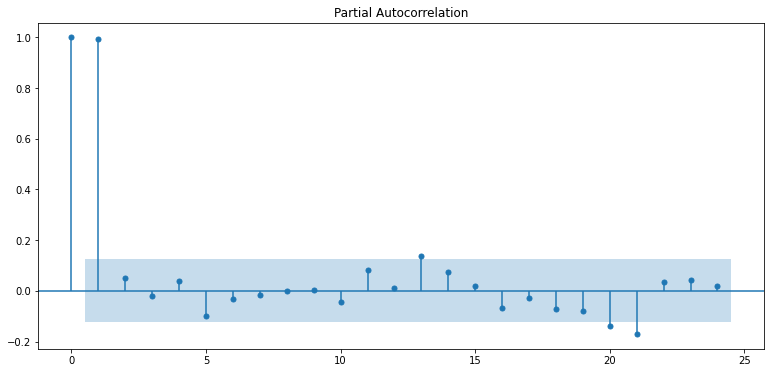

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF 그래프를 보면,MA모델의 시차 p는 p = 1이 적합
- ACF 그래프는 점차적으로 감소하고 있어서 AR(1) 모델에 유사
- q에 대해서는 적합한 값이 없음 q = 0으로 적용함

## 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


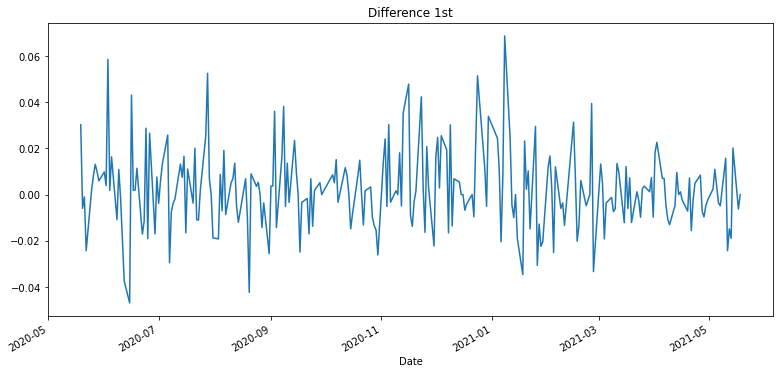

In [36]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


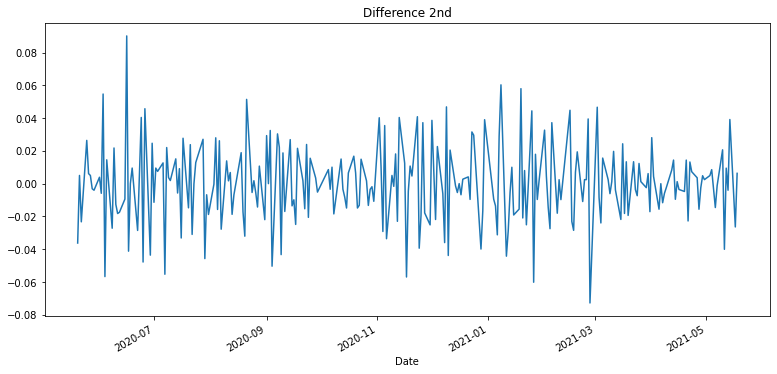

In [37]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분만으로도 안정화 상태
- 우선 d=1로 시도해보고 값을 바꿔보면서 최적의 값을 찾아봄

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [38]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # p,d,q = 1,1,0
fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Thu, 17 Feb 2022   AIC                          -1162.976
Time:                        07:31:52   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

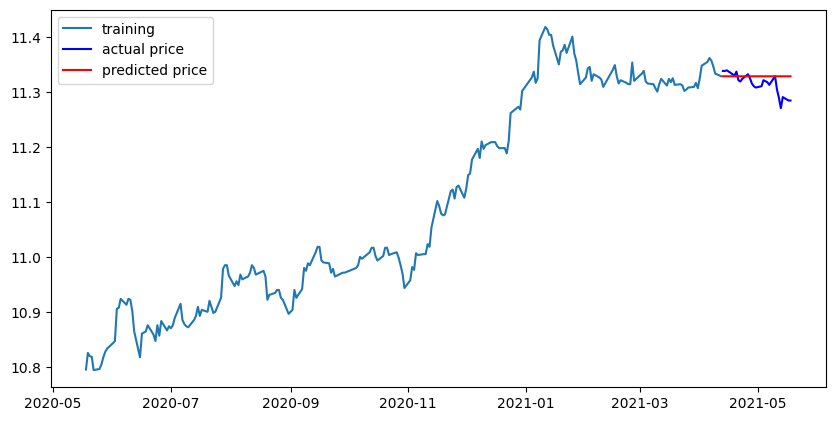

In [39]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


- MAPE: 1.74%으로 안정적으로 예측함

# 데이터
- TSLA 과거의 일자별 시세
- 데이터 기간 2021.02.017~2022.02.17
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 종가(Close)만 사용

In [41]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']    # 종가만 가져옴

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
2021-02-23    698.840027
Name: Close, dtype: float64

In [42]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,779.090027,799.840027,762.010010,798.150024,798.150024,25996500
2021-02-18,780.900024,794.690002,776.270020,787.380005,787.380005,17957100
2021-02-19,795.000000,796.789978,777.369995,781.299988,781.299988,18958300
2021-02-22,762.640015,768.500000,710.200012,714.500000,714.500000,37269700
2021-02-23,662.130005,713.609985,619.000000,698.840027,698.840027,66606900


In [43]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-10,908.369995,943.809998,896.700012,904.549988,904.549988,22042300
2022-02-11,909.630005,915.960022,850.700012,860.000000,860.000000,26492700
2022-02-14,861.570007,898.880005,853.150024,875.760010,875.760010,22515100
2022-02-15,900.000000,923.000000,893.380005,922.429993,922.429993,19216500
2022-02-16,914.049988,926.429993,901.210022,923.390015,923.390015,17027700


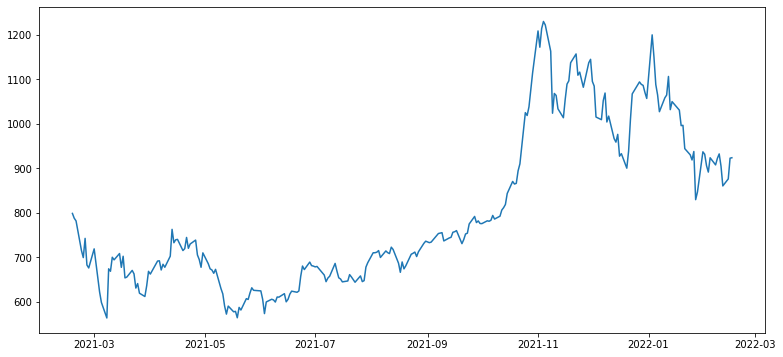

In [44]:
# 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

# STEP 2 : 각종 전처리 수행

## 결측치 처리

In [45]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

## 로그 변환

In [46]:
# 로그 변환 시도 
ts_log = np.log(ts)

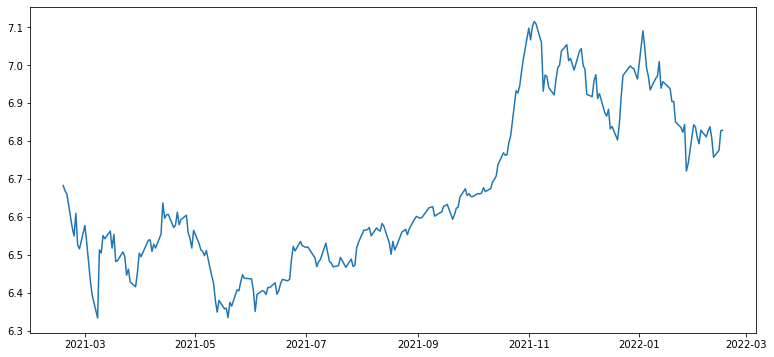

In [47]:
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [48]:
# 일정 시간 내 구간 통계치를 시각화해보기

def plot_rolling_statistics(timeseries, window=12):
    
    # 현재 타임스텝 ~ window에 주어진 타임스텝 이전 사이 구간의 평균, 표준편차
    rolmean = timeseries.rolling(window=window).mean()       # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std()         # 이동 표준편차 시계열
    
    # 원본 시계열, 이동 평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

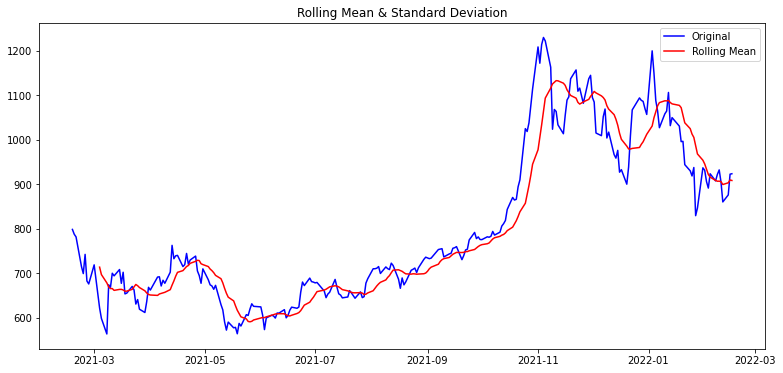

In [49]:
plot_rolling_statistics(ts, window=12)

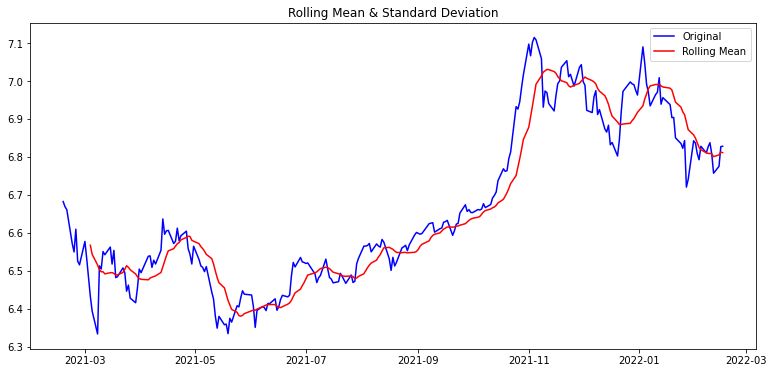

In [50]:
plot_rolling_statistics(ts_log, window=12)

# Stationary 여부 체크하기

## Augmented Dickey-Fuller Test

In [51]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [52]:
augmented_dickey_fuller_test(ts) 

Results of Dickey-Fuller Test:
Test Statistic                  -1.319322
p-value                          0.620287
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


- p-value : 0.620287

In [53]:
augmented_dickey_fuller_test(ts_log)   

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


# Moving average 제거
- 추세 상쇄하기 : Moving Average(rolling mean)을 구해서 ts_log에서 빼기

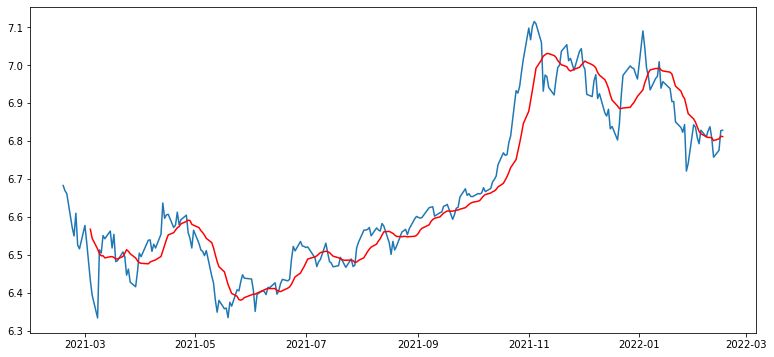

In [54]:
moving_avg = ts_log.rolling(window=12).mean()      
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [55]:
ts_log_moving_avg = ts_log - moving_avg  # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26         NaN
2021-03-01         NaN
2021-03-02         NaN
2021-03-03         NaN
2021-03-04   -0.135099
2021-03-05   -0.149566
2021-03-08   -0.181841
2021-03-09    0.009849
Name: Close, dtype: float64

In [56]:
# window size가 12이면 앞의 11개 데이터는 계산되지 않기 때문에 그로 인해 생기는 결측치를 제거

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(10)

Date
2021-03-04   -0.135099
2021-03-05   -0.149566
2021-03-08   -0.181841
2021-03-09    0.009849
2021-03-10    0.007221
2021-03-11    0.053261
2021-03-12    0.050443
2021-03-15    0.067636
2021-03-16    0.022600
2021-03-17    0.060719
Name: Close, dtype: float64

## 정성, 정량적 분석

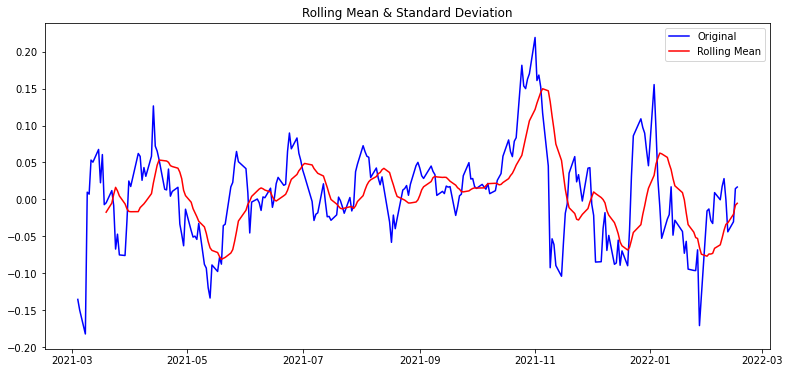

In [57]:
plot_rolling_statistics(ts_log_moving_avg)

In [58]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.567435
p-value                          0.000148
#Lags Used                       8.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


- p-value : 0.000148

In [59]:
# window = 6
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

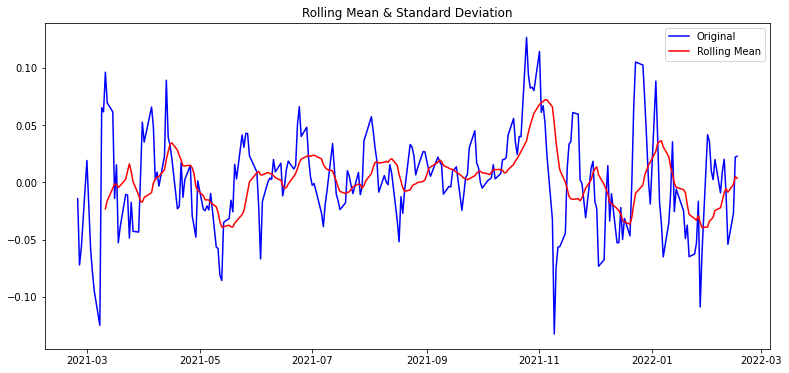

In [60]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [61]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)   

Results of Dickey-Fuller Test:
Test Statistic                -6.673564e+00
p-value                        4.523941e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


- window=12 보다 안정적으로 나옴

# 차분(Differencing) - 계절성(Seasonality) 상쇄하기

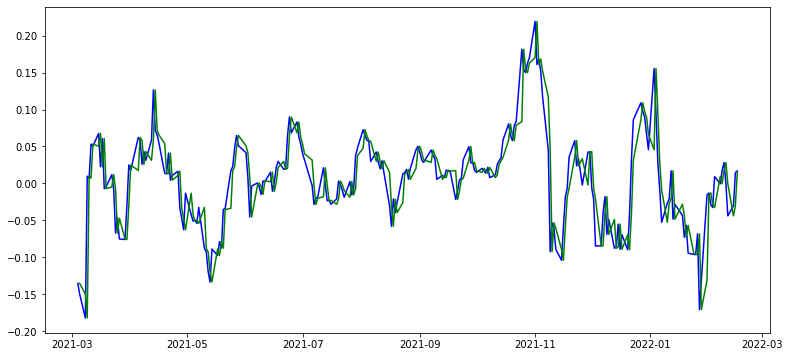

In [62]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

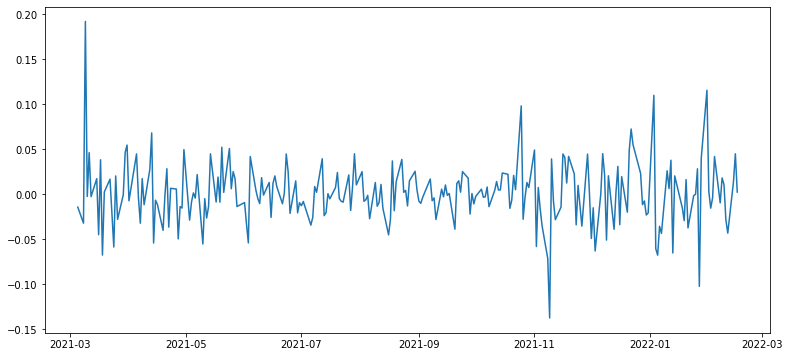

In [63]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

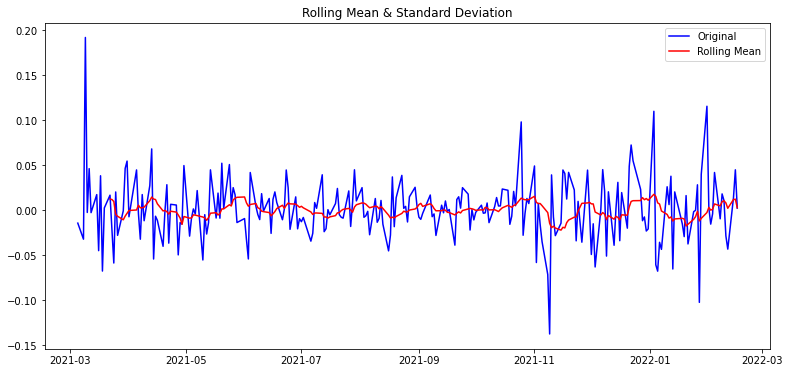

In [64]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [65]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.419086e+00
p-value                        6.811356e-11
#Lags Used                     1.000000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


- p-value : 6.811356e-11

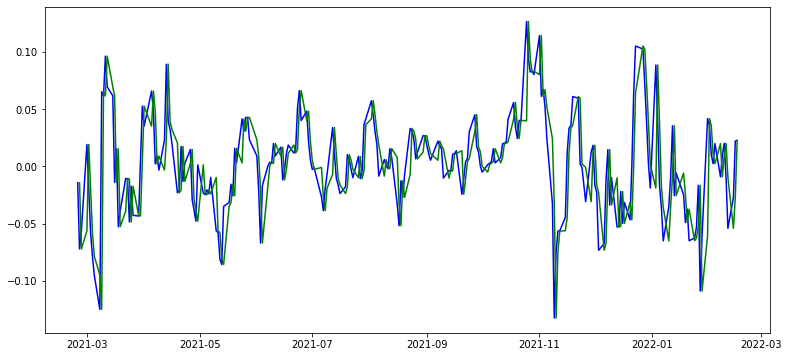

In [66]:
# 6개월 주기
ts_log_moving_avg_shift_6 = ts_log_moving_avg_6.shift()

plt.plot(ts_log_moving_avg_6, color='blue')
plt.plot(ts_log_moving_avg_shift_6, color='green')

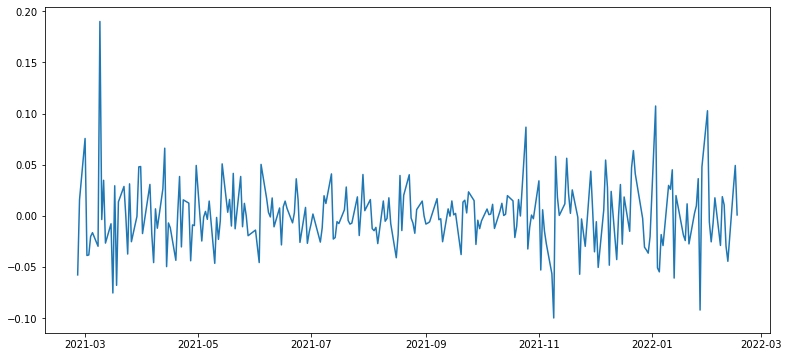

In [67]:
ts_log_moving_avg_diff_6 = ts_log_moving_avg_6 - ts_log_moving_avg_shift_6
ts_log_moving_avg_diff_6.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff_6)

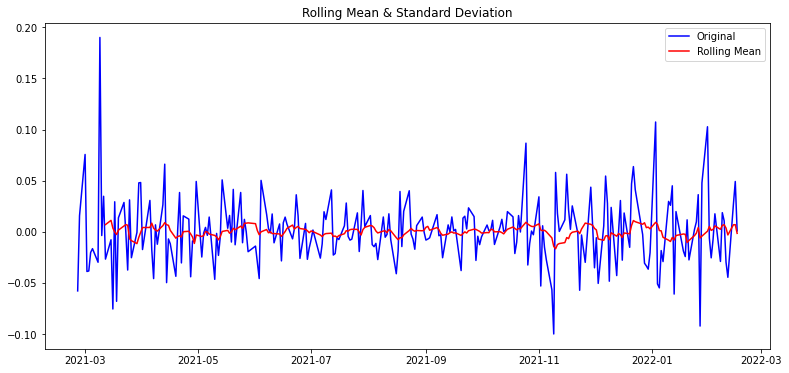

In [68]:
plot_rolling_statistics(ts_log_moving_avg_diff_6)

In [69]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff_6)

Results of Dickey-Fuller Test:
Test Statistic                -7.588909e+00
p-value                        2.562387e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


# 시계열 분해

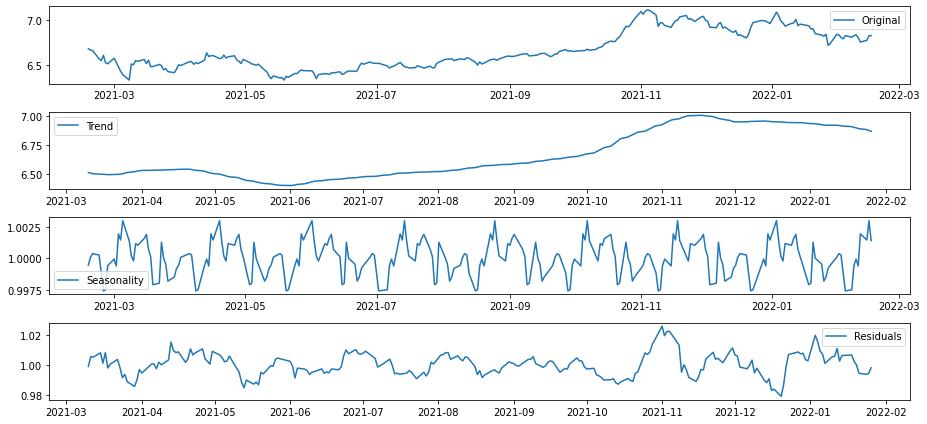

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')        # Residual = trend와 Seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

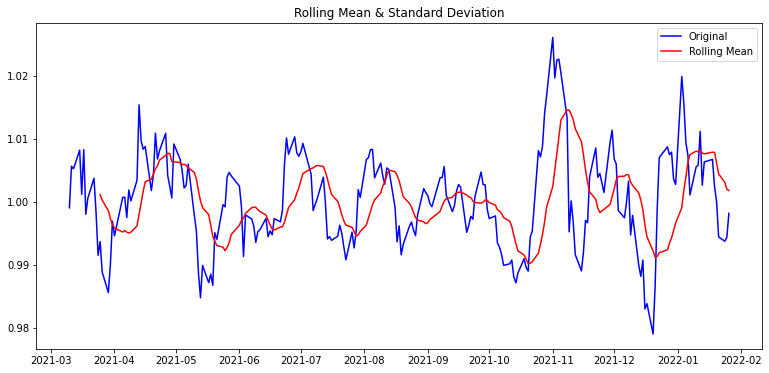

In [71]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [72]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.567501e+00
p-value                        8.089813e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


- p-value : 8.089813e-09

# STEP 4 : 학습, 테스트 데이터셋 생성

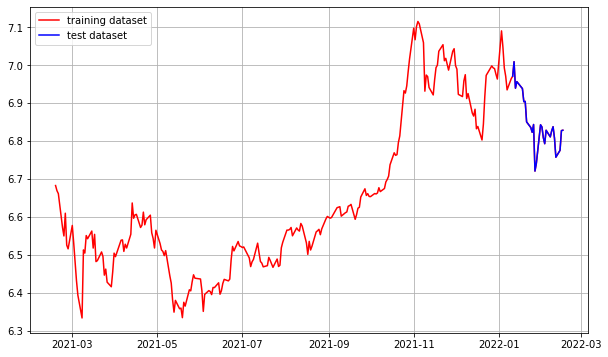

In [73]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [74]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-17    6.682297
2021-02-18    6.668711
Name: Close, dtype: float64
(228,)
(26,)


# STEP 5 : 적정 ARIMA 모수 찾기

## ACF, PACF 그려보기 -> p,q 구하기

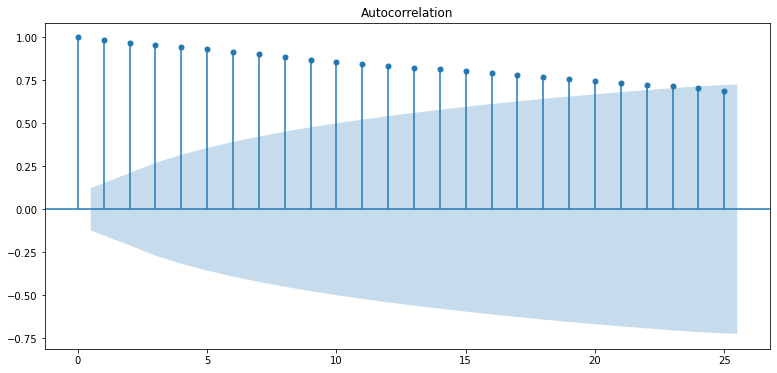

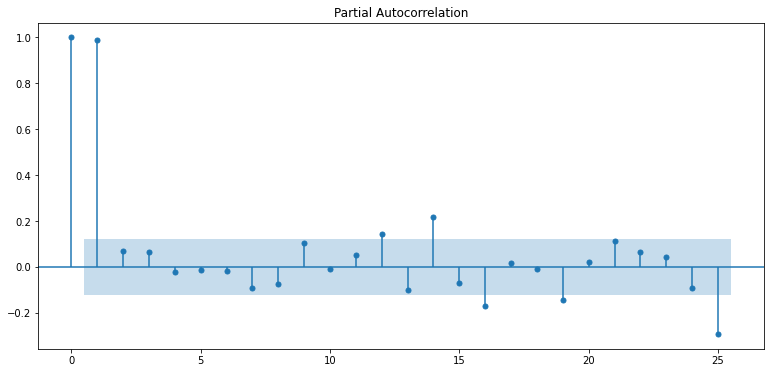

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF 그래프를 보면,MA모델의 시차 p는 p = 1이 적합
- ACF 그래프는 점차적으로 감소하고 있어서 AR(1) 모델에 유사
- q에 대해서는 적합한 값이 없음 q = 0으로 적용함

## 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


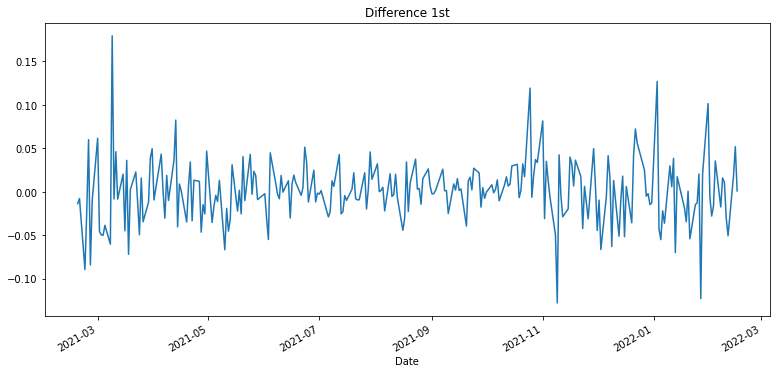

In [77]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


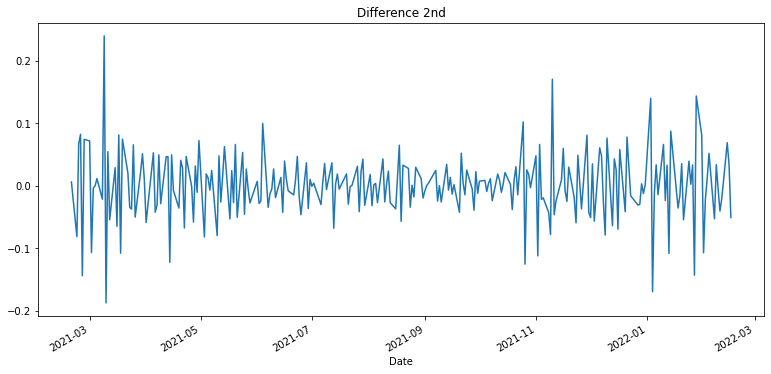

In [78]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분보다는 2차 차분이 더 안정적
- 우선 d=1로 시도

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [80]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))   # p,d,q = 1,1,0

fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 439.060
Date:                Thu, 17 Feb 2022   AIC                           -874.119
Time:                        07:32:18   BIC                           -867.270
Sample:                             0   HQIC                          -871.355
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0529      0.062     -0.856      0.392      -0.174       0.068
sigma2         0.0012   6.92e-05     17.687      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

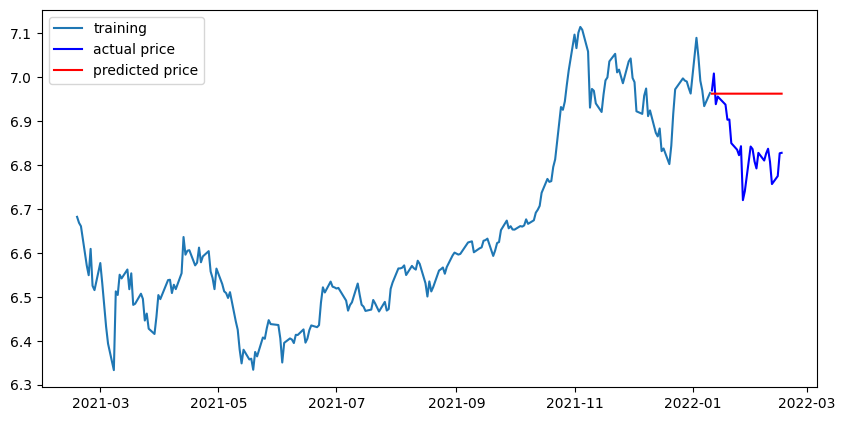

In [81]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17422.37411646884
MAE:  118.08076647256114
RMSE:  131.99384120658374
MAPE: 13.00%


- MAPE: 13.00%으로 더 성능을 개선 시킬 필요가 있음

#  예측 모델의 오차율 개선

## p,d,q = 1,1,1

In [83]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  # p,d,q = 1,1,1
fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 439.051
Date:                Thu, 17 Feb 2022   AIC                           -872.102
Time:                        07:32:19   BIC                           -861.827
Sample:                             0   HQIC                          -867.956
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0101      1.197     -0.008      0.993      -2.357       2.337
ma.L1         -0.0413      1.180     -0.035      0.972      -2.354       2.271
sigma2         0.0012   6.98e-05     17.519      0.0

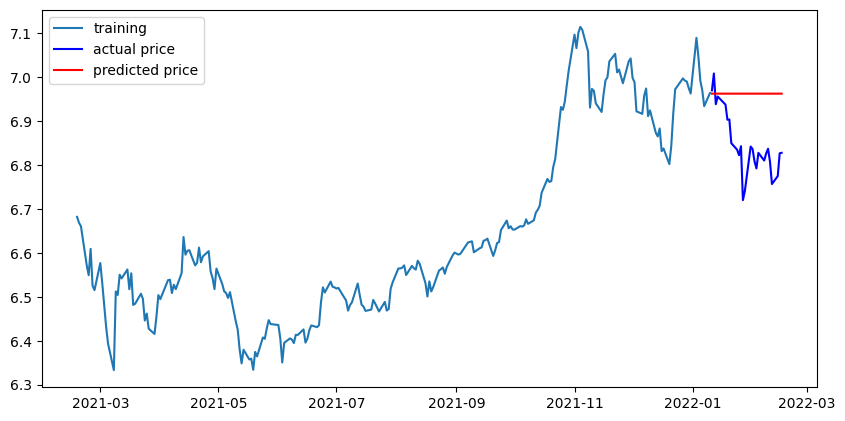

In [84]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [85]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17436.310862399903
MAE:  118.13026523116211
RMSE:  132.04662382052751
MAPE: 13.01%


- MAPE: 13.01%으로 0.01%가 증가

## p,d,q = 1,1,2

In [86]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 2))   # p,d,q = 1,1,2
fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 439.065
Date:                Thu, 17 Feb 2022   AIC                           -870.130
Time:                        07:32:19   BIC                           -856.430
Sample:                             0   HQIC                          -864.602
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2051      5.352     -0.038      0.969     -10.695      10.284
ma.L1          0.1530      5.359      0.029      0.977     -10.351      10.657
ma.L2          0.0018      0.289      0.006      0.9

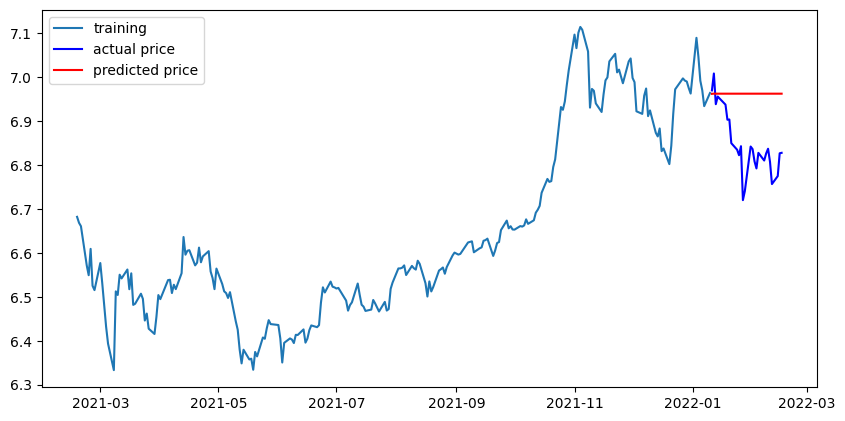

In [87]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [88]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17416.55113594072
MAE:  118.06777050499652
RMSE:  131.97178158962893
MAPE: 13.00%


- MAPE: 13.00%

## p,d,q = 1,1,3

In [89]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 3))  # p,d,q = 1,1,3
fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 439.409
Date:                Thu, 17 Feb 2022   AIC                           -868.817
Time:                        07:32:21   BIC                           -851.692
Sample:                             0   HQIC                          -861.907
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4058      1.153     -0.352      0.725      -2.665       1.854
ma.L1          0.3577      1.142      0.313      0.754      -1.881       2.597
ma.L2          0.0065      0.086      0.076      0.9

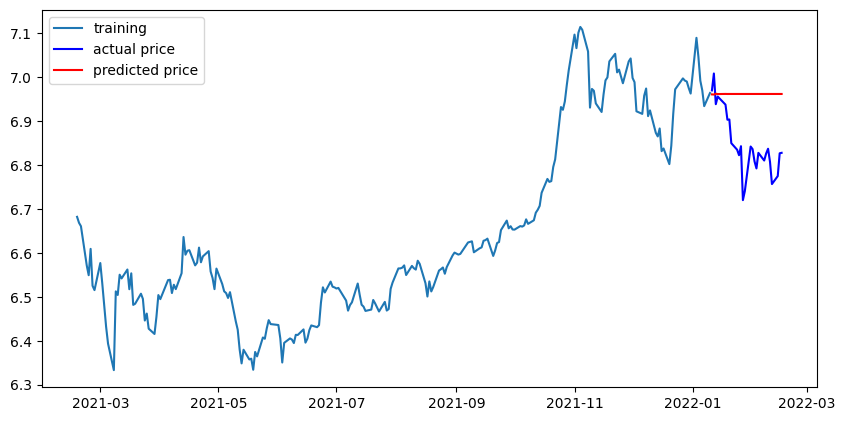

In [90]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [91]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17265.633546524834
MAE:  117.57282476246672
RMSE:  131.3987577815134
MAPE: 12.95%


- MAPE: 12.95% 으로 0.05%가 줄어듬

## p,d,q = 1,1,4

In [92]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 4))   # p,d,q = 1,1,4
fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 4)   Log Likelihood                 439.864
Date:                Thu, 17 Feb 2022   AIC                           -867.729
Time:                        07:32:22   BIC                           -847.179
Sample:                             0   HQIC                          -859.437
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0181      0.774     -0.023      0.981      -1.536       1.500
ma.L1         -0.0317      0.757     -0.042      0.967      -1.514       1.451
ma.L2          0.0353      0.076      0.463      0.6

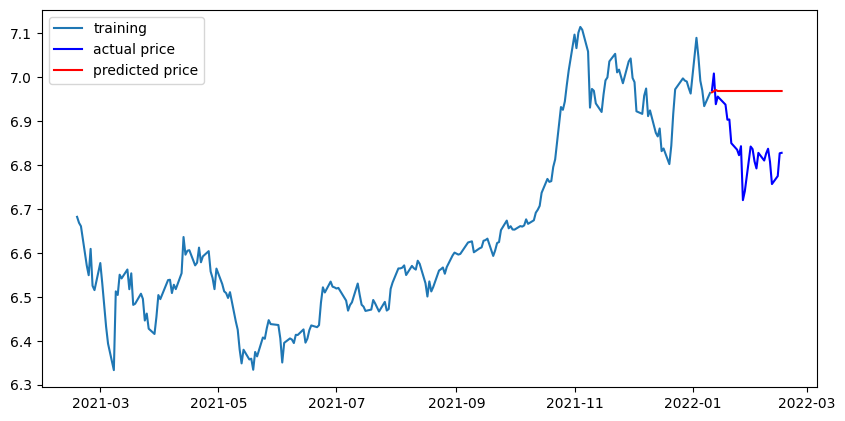

In [93]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [94]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18934.17649504108
MAE:  123.75004313550019
RMSE:  137.6015134184253
MAPE: 13.62%


## p,d,q = 2, 0, 5

In [95]:
# Build Model
model = ARIMA(train_data, order=(2, 0, 5))   # p,d,q = 2, 0, 5
fitted_m = model.fit()  
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 5)   Log Likelihood                 440.972
Date:                Thu, 17 Feb 2022   AIC                           -863.944
Time:                        07:32:24   BIC                           -833.080
Sample:                             0   HQIC                          -851.491
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7094      0.159     42.206      0.000       6.398       7.021
ar.L1          1.3447      0.908      1.482      0.138      -0.434       3.124
ar.L2         -0.3558      0.896     -0.397      0.6

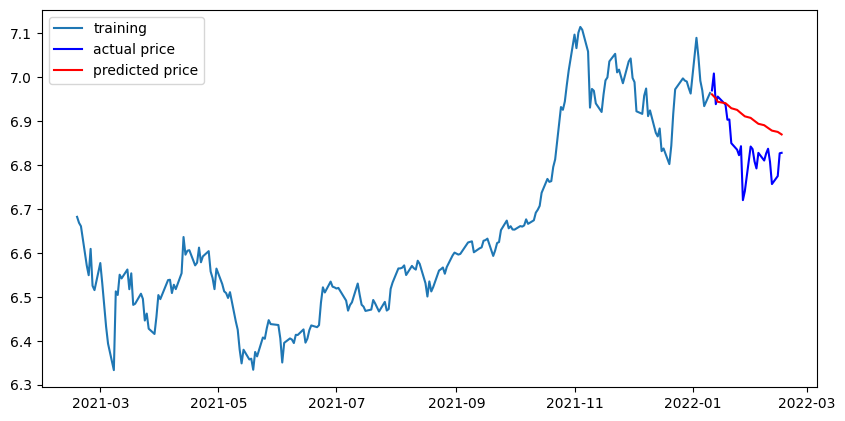

In [96]:
# Forecast : 결과가 fc에 담김 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [97]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6171.102016939055
MAE:  67.03861761133786
RMSE:  78.55636203986953
MAPE: 7.40%


- p,d,q = 2, 0, 5일때 MAPE가 7.40% 으로 가장 오차율이 작음

# 회고
- ARIMA모델을 활용하여 삼성전자와 테슬라의 주식을 예측해보았다. Stationary한 시계열로 가공하기 위해 로그함수 변환, Moving average 제거로 추세(Trend) 상쇄, 차분(Differencing)을 통해 계절성(Seasonality) 상쇄를 했다. 그 후 시계열 분해를 해서 pvalue를 낮출 수 있었다.
- 적정 ARIMA 모수 찾기 위해 ACF, PACF 그려서 p,q 구해보고 차분 안정성 확인으로 d 구하여 ARIMA 모델로 훈련시켰다. 그 결과로 삼성전자 주식 예측 모델에서는 p,d,q = 1,1,0일 때 MAPE가 1.74%으로, 테슬라 주식 예측 모델에서는 p,d,q = 2, 0, 5일때 MAPE가 7.40% 으로 안정적으로 예측했다.
- 과거에 선형회귀모델, randomforest, xgboost, lstm을 활용해서 주가 예측해서 어느 모델이 가장 성능이 좋은지 비교를 했던 프로젝트가 떠올랐다. 이번에 배우게 된 ARIMA모델을 활용하면서 시계열 데이터를 다양한 모델로 예측하고 각각의 성능들을 비교해보면 좋을 것 같다.
- 이번 프로젝트에 활용한 삼성, 테슬라의 주식 데이터 기간이 1년이어서 해당 회사의 전체 주식 데이터로 기간을 늘린다면 예측의 정확도를 더 올릴 수 있을 것 같다.